# Loading python libraries
#### Python is developed under an OSI-approved open source license, making it freely usable and distributable, even for commercial use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import glob
from sklearn import preprocessing
from pysptools import spectro as sp
from pysptools import distance
from IPython.display import display
import ipywidgets as widgets
from math import*
from ipywidgets import IntProgress

# Loading Functions

* Widegets
    * on_value_change_min - this function monitors the change in value of the slider
    * on_value_change_max - this function monitors the change in value of the slider
* FolderAndFileProcessing
    * ReadFilePaths - This function takes input as source folder and file extension and returns the path of all the files inside the folder with the supplied extension
    * ReadFile - This functions purpose is to read individual file, it takes file path, rows to skip while reading the file and type of seperation as input
    * GetValuesFromFile - This function uses ReadFile read a file and then filters out desired column
    * WriteDictToExcel - This function is used to write the output of the analysis to excel file
    * combine_dicts - This function is used to combine two dictionaries in python into one dictionary
* SpectraComparision(all functions normalizes and removes continum after subsetting the spectral signals)
    * SFF - This function takes reference spectra and user input spectrum as input and process the signals using root mean squared algorithm and generates the score table with most probable mineral having the least score
    * SAM - This function takes reference spectra and user input spectrum as input and process the signals using root mean squared algorithm and generates the score table with most probable mineral having the least score
    * SFF_CrossCorrelation - This function takes reference spectra and user input spectrum as input and process the signals using cross-correlation algorithm and generates the score table with most probable mineral having the highest score(closer to 1) and least probable mineral having the lowest score(closer to -1)
    * SpectralInformationDivergence - Computes the spectral information divergence between two vectors.

In [2]:
### https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/
### https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

class Widegets:
    def on_value_change_min(change):
        new_min = change['new']
        #print(change['name'])
        if new_min + 100 > maxWavelength.value:
            minWavelength.value = maxWavelength.value - 100

    def on_value_change_max(change):
        new_max = change['new']
        if minWavelength.value > new_max - 100:
            maxWavelength.value = minWavelength.value + 100
        
class FolderAndFileProcessing:
    def ReadFilePaths(source, ext):
        return glob.glob(source + "/**/*." + ext, recursive = True)
    
    def ReadFile(file, rowToSkip, seperation):
        return pd.read_csv(file ,skiprows = rowToSkip, sep = seperation) 
    
    def GetValuesFromFile(file, rowToSkip, seperation, column):
        fileData = FolderAndFileProcessing.ReadFile(file , rowToSkip, seperation)
        return fileData[column]
    
    def WriteDictToExcel(targetPath, filename, dictionary):
        df = pd.DataFrame.from_dict(dictionary)
        os.makedirs(targetPath, exist_ok=True)
        df.to_excel(targetPath+filename)
    
    def combine_dicts(a, b):
        for key in b:
            if key in a:
                b[key] = b[key] + a[key]
        c = {**a, **b}
        return c
        
class SpectraComparision:
    
    def SFF_CrossCorrelation(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndex:maxIndex], waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            result = np.corrcoef(continumRemoved_spectraValue, continumRemoved_idealReflectance)
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def SFF(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndex:maxIndex], waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            result = np.array(continumRemoved_spectraValue) - np.array(continumRemoved_idealReflectance)
            score = np.sqrt(np.mean(result**2))
            score = 1 - score
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def CosineSimilarityContinumRemoved(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndex:maxIndex], waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = SpectraComparision.cosine_similarity(continumRemoved_spectraValue, continumRemoved_idealReflectance)
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def computeSimilarityContinumRemoved(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndex:maxIndex], waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = SpectraComparision.compute_similarity(continumRemoved_spectraValue, continumRemoved_idealReflectance)
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def SAM(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]
        try:
            continumRemoved_spectraValue = normalized_spectraValue
            #continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndex:maxIndex], waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SAM(continumRemoved_spectraValue, continumRemoved_idealReflectance)
            score = 1 - score
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore

    def chebyshev(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndex:maxIndex], waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.chebyshev(np.array(continumRemoved_spectraValue), np.array(continumRemoved_idealReflectance))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore

    def SpectralInformationDivergence(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndex:maxIndex], waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SID(continumRemoved_spectraValue, continumRemoved_idealReflectance)
            score = 1 - score
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def compute_similarity(ref_rec,input_rec,weightage=[0.33,0.33,0.33]):
        ref_rec = np.array(ref_rec)
        input_rec = np.array(input_rec)
        ## Time domain similarity
        ref_time = np.correlate(ref_rec,ref_rec)    
        inp_time = np.correlate(ref_rec,input_rec)
        diff_time = abs(ref_time-inp_time)

        ## Freq domain similarity
        ref_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(ref_rec)) 
        inp_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(input_rec))
        diff_freq = abs(ref_freq-inp_freq)

        ## Power similarity
        ref_power = np.sum(ref_rec**2)
        inp_power = np.sum(input_rec**2)
        diff_power = abs(ref_power-inp_power)
        
        return float(weightage[0]*diff_time+weightage[1]*diff_freq+weightage[2]*diff_power)
    

    
    def square_rooted(x):
        return round(sqrt(sum([a*a for a in x])),3)
 
    def cosine_similarity(x,y):
        numerator = sum(a*b for a,b in zip(x,y))
        denominator = SpectraComparision.square_rooted(x)* SpectraComparision.square_rooted(y)
        #return round(numerator/float(denominator),3)
        return numerator/float(denominator)
    

### Variable Declarations

In [3]:
##txt file declarations
#txtPath = "../data/enviData/cleanFolder/"
txtPath = "../data/enviData/ENVIFilesUsgsProcessed/"
extensionTxt= 'txt'
indidualplotlimit = 15
limit = 6

###sed file declarations
#sedPath = "../data/vulcano/16062019/"
sedPath = "../data/vulcano/"
extensionSed= 'sed'

minWavelength = []
maxWavelength = []

minIndex = []
maxIndex = []


numberOfFeatureToAnalyze = int(input("Enter the totlal number of features you want to anaylze: "))


Enter the totlal number of features you want to anaylze: 1


# Image Selection
### Select if you want to plot graph or not

In [4]:
toggleButton = widgets.ToggleButtons(
    options=['No Image', 'Image'],
    description='Select:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Generates only excel file', 'Generates excel files with graph plots'],
#    icons=['check'] * 3
)
#toggleButton.observe(Widegets.on_value_change_toggle, names='value')

In [6]:
display(toggleButton)

ToggleButtons(description='Select:', index=1, options=('No Image', 'Image'), tooltips=('Generates only excel f…

# Full Plot
### Select if you want to plot graph for the entire spectral range

In [7]:
toggleButtonFullPlot = widgets.ToggleButtons(
    options=['Yes', 'No'],
    description='Select:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Also Generates Full plot', 'Only generates plot of selected region'],
#    icons=['check'] * 3
)

In [9]:
display(toggleButtonFullPlot)

ToggleButtons(description='Select:', index=1, options=('Yes', 'No'), tooltips=('Also Generates Full plot', 'On…

# Individual plots
### Select if you want to plot the graph for all the minerals together or each probale output as sepererate graph plot

In [10]:
toggleButtonIndividualPlot = widgets.ToggleButtons(
    options=['Yes', 'No'],
    description='Select:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Generates Individual plots', 'Generates Combined Plots'],
#    icons=['check'] * 3
)

In [12]:
display(toggleButtonIndividualPlot)

ToggleButtons(description='Select:', options=('Yes', 'No'), tooltips=('Generates Individual plots', 'Generates…

# Declaring dynamic functions
### Creating dynamic functions so the code if more adaptable and not hardcoded

In [13]:
for i in range(numberOfFeatureToAnalyze):
    exec(f"""def on_value_change_min_{i}(change): 
         new_min = change['new']
         if new_min + 100 > maxWavelength[{i}].value:
             minWavelength[{i}].value = maxWavelength[{i}].value - 100""")
    
    exec(f"""def on_value_change_max_{i}(change): 
         new_max = change['new']
         if minWavelength[{i}].value > new_max - 100:
             maxWavelength[{i}].value = minWavelength[{i}].value + 100""")

In [14]:
###Descibing wavelengths
for ind in range(numberOfFeatureToAnalyze):
    minWavelength.append(widgets.IntSlider(value=350, min=350, max=2500))
    maxWavelength.append(widgets.IntSlider(value=2500, min=350, max=2500))
    minWavelength[ind].description = 'min wav'
    maxWavelength[ind].description = 'max wav'
        
    minWavelength[ind].observe(globals()['on_value_change_min_'+ str(ind)], names='value')
    maxWavelength[ind].observe(globals()['on_value_change_max_'+ str(ind)], names='value')

# Select the wavelength range
### Select the range to subset the data

In [15]:
for ind in range(numberOfFeatureToAnalyze):
    print('feature' + str(ind+1))
    display(minWavelength[ind], maxWavelength[ind])

feature1


IntSlider(value=350, description='min wav', max=2500, min=350)

IntSlider(value=2500, description='max wav', max=2500, min=350)

In [16]:
minIndex = []
maxIndex = []
for ind in range(numberOfFeatureToAnalyze):
    minIndex.append(minWavelength[ind].value - 350)
    maxIndex.append(maxWavelength[ind].value - 350 + 1)

In [17]:
maxIndex[0]

1051

# Populating paths
### Getting the paths to both reference spectrum and user input spectrum

In [18]:
txt_files = FolderAndFileProcessing.ReadFilePaths(txtPath,extensionTxt)
sed_files = FolderAndFileProcessing.ReadFilePaths(sedPath,extensionSed)

# Defining wavelength range

In [19]:
waveLength = list(range(350,2501))

# Continium removal after splicing the data
### Splice the ideal spectral data and remove the continium

In [20]:
max_count = len(txt_files)
for ind in range(numberOfFeatureToAnalyze):
    minIndexTemp = minIndex[ind]
    maxIndexTemp = maxIndex[ind]
    globals()['fileListContinumRemoval_'+str(ind)] = []
    globals()['progreesBar'+str(ind)] = IntProgress(min=0, max=max_count) # instantiate the bar
    display(globals()['progreesBar'+str(ind)]) # display the bar

    for index in range(len(txt_files)):
        idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
        normalized_idealReflectance = preprocessing.normalize([idealReflectance[minIndexTemp:maxIndexTemp]])[0]
        continumRemoved_idealReflectance = normalized_idealReflectance
        #continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance[minIndexTemp:maxIndexTemp], waveLength[minIndexTemp:maxIndexTemp])[0]
        globals()['fileListContinumRemoval_'+str(ind)].append(continumRemoved_idealReflectance)
        globals()['progreesBar'+str(ind)].style = {'description_width': 'initial'}
        globals()['progreesBar'+str(ind)].description = 'Loading ideal files feature '+ str(ind + 1) + ': ' + str(index + 1) + '/' + str(max_count)
        globals()['progreesBar'+str(ind)].value += 1 # signal to increment the progress bar
        
        

IntProgress(value=0, max=481)

### Remove the continium from the entire wavelegth of ideal spectral data 

In [21]:

fileListContinumRemoval = []
max_count = len(txt_files)

if toggleButtonFullPlot.value == 'Yes':
    progreesBar = IntProgress(min=0, max=max_count) # instantiate the bar
    display(progreesBar) # display the bar
    
    for index in range(len(txt_files)):
        idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
        normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
        continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
        fileListContinumRemoval.append(continumRemoved_idealReflectance)
        #counter = counter + 1
        #print('processed ' + str(counter))
        progreesBar.style = {'description_width': 'initial'}
        progreesBar.description = 'Loading ideal files ' + str(index + 1)
        progreesBar.value += 1 # signal to increment the progress bar

# Analysis
### Taking user data as input and writing the result in similar type of folder structure with weighted output for each input data stored with similar name in an excel file and graph plots stored as png

In [22]:
max_countSed = len(sed_files)
progreesBarSed = IntProgress(min=0, max=max_countSed) 
display(progreesBarSed)
targetFolderToReplace = '/data'
targetFolderNewName = '/SAM_700-1400_15Top'

for index in range(len(sed_files)):
    totalDict = {}
    targetfilename = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[-1].replace('.sed','.xlsx')
    list_string = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    testData = FolderAndFileProcessing.GetValuesFromFile(sed_files[index], 26, '\t','Reflect. [1.0]')
    minIndexTemp = 0
    maxIndexTemp = 0
    for indexRange in range(numberOfFeatureToAnalyze):
        minIndexTemp = minIndex[indexRange]
        maxIndexTemp = maxIndex[indexRange]
        dictMineralValue = SpectraComparision.SAM(txt_files, testData, globals()['fileListContinumRemoval_'+str(indexRange)], waveLength, minIndexTemp, maxIndexTemp)
        if len(totalDict) == 0:
            totalDict = dict(dictMineralValue)
        else:
            tempDict = dict(dictMineralValue)
            totalDict = FolderAndFileProcessing.combine_dicts(totalDict, tempDict)
    totalDict = {k: v / numberOfFeatureToAnalyze for k, v in dict(totalDict).items()}
    totalDict = sorted(totalDict.items(), key=lambda x: x[1], reverse=True)
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, totalDict)
    
    
    if toggleButton.value == 'No Image':
        continue
    
    
    if toggleButtonIndividualPlot.value == 'No':
        
        try:
            counterMineral = 0
            mineralNameList = [i for i,j in totalDict]
            mineralNameListPruned = [i.split(' ')[0] for i in mineralNameList]
            #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
            
            normalized_spectraValue = preprocessing.normalize([testData])[0]
            
            minIndexTemp = 0
            maxIndexTemp = 0
            
            for indexRange in range(numberOfFeatureToAnalyze):
                minIndexTemp = minIndex[indexRange]
                maxIndexTemp = maxIndex[indexRange]
                
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndexTemp:maxIndexTemp], waveLength[minIndexTemp:maxIndexTemp])[0]
                xaxis = list(range(minWavelength[indexRange].value,maxWavelength[indexRange].value + 1))
                fig = plt.figure(figsize=(24, 12))
                plt.plot(xaxis, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < limit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split(' ')[0]] == False:
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = globals()['fileListContinumRemoval_'+str(indexRange)][txt_files.index(imagePath)]
                        plt.plot(xaxis, signal, label = mineralName)
                        mineralNameListDict[mineralName.split(' ')[0]] = True
                        counterMineral = counterMineral + 1
                    
                    indexForWhile = indexForWhile + 1
                imageLabelRange = '_' + str(minIndexTemp + 350) + '_' + str(maxIndexTemp + 350 - 1)
                plt.legend(loc="lower right")
                plt.savefig(sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed',imageLabelRange + '.png'), dpi=500)
                plt.close()
        except:
            continue
        
        if toggleButtonFullPlot.value == 'Yes':
            try:
                counterMineral = 0
                mineralNameList = [i for i,j in totalDict]
                mineralNameListPruned = [i.split(' ')[0] for i in mineralNameList]
                
                normalized_spectraValue = preprocessing.normalize([testData])[0]
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
                
                
                    
                fig = plt.figure(figsize=(24, 12))
                plt.plot(waveLength, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                    
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < limit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split(' ')[0]] == False:
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = continumRemoved_spectraValue[txt_files.index(imagePath)]
                        plt.plot(waveLength, signal, label = mineralName)
                        mineralNameListDict[mineralName.split(' ')[0]] = True
                        counterMineral = counterMineral + 1
                    
                    indexForWhile = indexForWhile + 1
                imageLabelRange = '_FullPlot'
                plt.legend(loc="lower right")
                plt.savefig(sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed',imageLabelRange + '.png'), dpi=500)
                plt.close()
            except:
                continue
            
            
            
            
            
            
        
     
    
    
    else:
        try:
            counterMineral = 0
            mineralNameList = [i for i,j in totalDict]
            mineralNameListPruned = [i.split(' ')[0] for i in mineralNameList]
            #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
        
            normalized_spectraValue = preprocessing.normalize([testData[minIndexTemp:maxIndexTemp]])[0]
            
            minIndexTemp = 0
            maxIndexTemp = 0
            
            for indexRange in range(numberOfFeatureToAnalyze):
                minIndexTemp = minIndex[indexRange]
                maxIndexTemp = maxIndex[indexRange]
                
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength[minIndexTemp:maxIndexTemp])[0]
                #continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue[minIndexTemp:maxIndexTemp], waveLength[minIndexTemp:maxIndexTemp])[0]
                xaxis = list(range(minWavelength[indexRange].value,maxWavelength[indexRange].value + 1))
                
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < indidualplotlimit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split(' ')[0]] == False:
                        fig = plt.figure(figsize=(24, 12))
                        plt.plot(xaxis, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                        
                        
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = globals()['fileListContinumRemoval_'+str(indexRange)][txt_files.index(imagePath)]
                        signal = sp.convex_hull_removal(signal, waveLength[minIndexTemp:maxIndexTemp])[0]
                        plt.plot(xaxis, signal, label = mineralName)
                        mineralNameListDict[mineralName.split(' ')[0]] = True
                        counterMineral = counterMineral + 1
                        
                        targertFolderImages = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed','') + '/'
                        
                        os.makedirs(targertFolderImages, exist_ok=True)
                        imageLabelRange = '_' + str(minIndexTemp + 350) + '_' + str(maxIndexTemp + 350 - 1)
                        individualImagePath = targertFolderImages + str(counterMineral) + '_' + mineralName.split('_')[0] + imageLabelRange + '.png'
                        
                        plt.legend(loc="lower right")
                        plt.savefig(individualImagePath, dpi=100)
                        plt.close()
                    
                    indexForWhile = indexForWhile + 1
        except:
            continue
            
        
        if toggleButtonFullPlot.value == 'Yes':
            try:
                counterMineral = 0
                mineralNameList = [i for i,j in totalDict]
                mineralNameListPruned = [i.split(' ')[0] for i in mineralNameList]
            
                normalized_spectraValue = preprocessing.normalize([testData])[0]
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
                
                
                for indexRange in range(numberOfFeatureToAnalyze):
                    
                    indexForWhile = 0
                    counterMineral = 0
                    mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                    while counterMineral < indidualplotlimit:
                        mineralName = totalDict[indexForWhile][0]
                        
                        if mineralNameListDict[mineralName.split(' ')[0]] == False:
                            fig = plt.figure(figsize=(24, 12))
                            plt.plot(waveLength, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                            
                            
                            imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                            signal = fileListContinumRemoval[txt_files.index(imagePath)]
                            plt.plot(waveLength, signal, label = mineralName)
                            mineralNameListDict[mineralName.split(' ')[0]] = True
                            counterMineral = counterMineral + 1
                            
                            targertFolderImages = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed','') + '/fullWavelength/'
                            
                            os.makedirs(targertFolderImages, exist_ok=True)
                            individualImagePath =  targertFolderImages + str(counterMineral) + '_' + mineralName.split('_')[0] + '.png'
                            
                            plt.legend(loc="lower right") 
                            plt.savefig(individualImagePath, dpi=100)
                            plt.close()
                        
                        indexForWhile = indexForWhile + 1
            except:
                continue
             
            
    progreesBarSed.style = {'description_width': 'initial'}
    progreesBarSed.description = 'Processing files ' + str(index + 1)
    progreesBarSed.value += 1 # signal to increment the progress bar
            

IntProgress(value=0, max=370)

# Testing Section
### Everything below this section is to test new machanism or to check if something goes wrong above

In [36]:
###sed file declarations
testSedPath = "../testMineral/"
testSed_files = FolderAndFileProcessing.ReadFilePaths(testSedPath,extensionTxt)

In [ ]:
for index in range(len(testSed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(testSed_files[index], 0, ' ','reflectance')
    dictMineralValue = SpectraComparision.SFF(txt_files, testData,fileListContinumRemoval, waveLength, minIndex, maxIndex)
    targetfilename = testSed_files[index].replace('/testMineral','/testDataScoreRemoved').split('/')[-1].replace('.txt','.xlsx')
    list_string = testSed_files[index].replace('/testMineral','/testDataScoreRemoved').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

In [ ]:
for index in range(len(testSed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(testSed_files[index], 26, '\t','Reflect. [1.0]')
    dictMineralValue = SpectraComparision.CosineSimilarityContinumRemoved(txt_files, testData,fileListContinumRemoval, waveLength, minIndex, maxIndex)
    targetfilename = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[-1].replace('.sed','.xlsx')
    list_string = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

In [ ]:
testSed_files[0]

In [31]:
tt = pd.read_csv(testSed_files[0] ,skiprows = 26, sep = '\t')

In [32]:
ww = tt['Reflect. [1.0]']

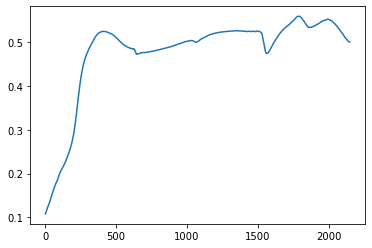

In [33]:
plt.plot(ww)

In [34]:
aa = sp.convex_hull_removal(ww,list(range(350,2501)))

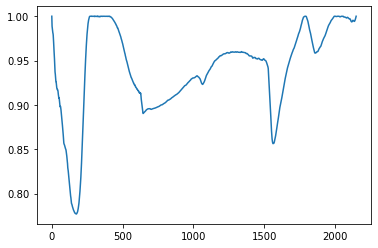

In [35]:
plt.plot(aa[0])

In [ ]:
plt.plot(fileListContinumRemoval[0])

In [ ]:
def compute_similarity(ref_rec,input_rec,weightage=[0.33,0.33,0.33]):
    ## Time domain similarity
    ref_time = np.correlate(ref_rec,ref_rec)    
    inp_time = np.correlate(ref_rec,input_rec)
    diff_time = abs(ref_time-inp_time)

    ## Freq domain similarity
    ref_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(ref_rec)) 
    inp_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(input_rec))
    diff_freq = abs(ref_freq-inp_freq)

    ## Power similarity
    ref_power = np.sum(ref_rec**2)
    inp_power = np.sum(input_rec**2)
    diff_power = abs(ref_power-inp_power)

    return float(weightage[0]*diff_time+weightage[1]*diff_freq+weightage[2]*diff_power)

In [ ]:
compute_similarity(np.array(fileListContinumRemoval[6]), np.array(aa[0]))

In [ ]:
aa[0]

In [ ]:
ref_time

In [ ]:
len(minIndex)